In [2]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: gpg 1.16.0-unknown has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Disc

In [1]:
#@title Import MuJoCo, MJX, and Brax

from datetime import datetime
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Tuple, Union

from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, State
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import functools
from datetime import datetime
from brax import envs
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
#@title Create Environment With Scaling Variables
import sys
import numpy as np
from env_model_generator import humanoid_genesis
from train import tRain
from HumanoidEnv import createIt
from base_env import MjxEnv

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
epsilon = 0.1
init_training_state = None
num_scaling_var = 17 # Must be tuned according to the base model
init_scaling_vars = np.zeros(num_scaling_var)
N = 5
path_to_base_env = "/home/name/Desktop/Codes/ScalingOptimization (1)"
num_iterations_to_go = 500
mutation_limits_wstrt = {
    "max" : [epsilon for i in range(num_scaling_var)],
    "min" : [-epsilon for i in range(num_scaling_var)]
}
mutation_limits_explr = {
    "max" : [2*epsilon for i in range(num_scaling_var)],
    "min" : [-2*epsilon for i in range(num_scaling_var)]
}
num_evals = 5
eelim_factor = 0.21 # Early Elimination Limiting Factor

In [7]:
init_env = envs.get_environment (createIt(humanoid_genesis([0 for i in range(num_scaling_var)], "init"), "init"))


jit_reset = jax.jit(init_env.reset)
jit_step = jax.jit(init_env.step)

# instantiate the renderer
%env MUJOCO_GL=glx
renderer = None
renderer = mujoco.Renderer(init_env.model, width = 1920, height = 1080 )

env: MUJOCO_GL=glx


In [4]:
path = humanoid_genesis([0 for i in range(num_scaling_var)], "standup", base_path = "/home/name/Desktop/Codes/Data/Xml_files/humanoid_contact.xml")
#@title Humanoid Env
class HumanoidStandUp(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(-2.0, 7.0),
      healthy_x_range=(-30.0, 20.0),
      healthy_y_range=(-10.0, 10.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
      mj_model = mujoco.MjModel.from_xml_path(path)
      mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
      mj_model.opt.iterations = 6
      mj_model.opt.ls_iterations = 6
      physics_steps_per_control_step = 5
      kwargs['physics_steps_per_control_step'] = kwargs.get(
          'physics_steps_per_control_step', physics_steps_per_control_step)

      super().__init__(mj_model=mj_model, **kwargs)

      self.x_velocity_after = 0
      self.x_velocity_before = 0

      self._forward_reward_weight = forward_reward_weight
      self.tt_penalty = 0
      self._ctrl_cost_weight = ctrl_cost_weight
      self._healthy_reward = healthy_reward
      self._terminate_when_unhealthy = terminate_when_unhealthy
      self._healthy_x_range = healthy_x_range
      self._healthy_y_range = healthy_y_range
      self._healthy_z_range = healthy_z_range
      self._reset_noise_scale = reset_noise_scale
      self._exclude_current_positions_from_observation = (
          exclude_current_positions_from_observation
      )

  def reset(self, rng: jp.ndarray) -> State:
      """Resets the environment to an initial state."""
      rng, rng1, rng2 = jax.random.split(rng, 3)

      low, hi = -self._reset_noise_scale, self._reset_noise_scale
      qpos = self.sys.qpos0 + jax.random.uniform(
          rng1, (self.sys.nq,), minval=low, maxval=hi
      )
      qvel = jax.random.uniform(
          rng2, (self.sys.nv,), minval=low, maxval=hi
      )

      data = self.pipeline_init(qpos, qvel)

      obs = self._get_obs(data, jp.zeros(self.sys.nu))
      reward, done, zero = jp.zeros(3)
      metrics = {
          'uph_cost' : zero,
          'reward_quadctrl': zero,
      }
      return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
      """Runs one timestep of the environment's dynamics."""

      data0 = state.pipeline_state
      data = self.pipeline_step(data0, action)

      com_after = data.subtree_com[2]
      uph_cost = (com_after[2] - 0) / self.dt



      ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
      obs = self._get_obs(data, action)
      reward = uph_cost - ctrl_cost + 2
      reward *= 0.01
      print("ctrl_cost:", ctrl_cost)
      state.metrics.update(
          uph_cost = uph_cost,
          reward_quadctrl=-ctrl_cost,
      )
      return state.replace(
          pipeline_state=data, obs=obs, reward=reward, done=0.0
      )
  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
      """Observes humanoid body position, velocities, and angles."""
      position = data.qpos
      if self._exclude_current_positions_from_observation:
          position = position[2:]

      # external_contact_forces are excluded
      return jp.concatenate([
          position,
          data.qvel,
          data.cinert[1:].ravel(),
          data.cvel[1:].ravel(),
          data.qfrc_actuator,
      ])

envs.register_environment("HumStandUp", HumanoidStandUp)

In [5]:
pt_env = envs.get_environment ("HumStandUp")

In [6]:
num_evals = 10
train_fn = functools.partial(
    tRain, num_timesteps=20_000_000, num_evals=num_evals, reward_scaling=0.001,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 5000, 0

rew_lower_limit = lambda r,t: r*jp.exp(eelim_factor*(t-num_evals+1))

def progress(num_steps, metrics, cmprsn_rewards = None):
  #Array data update
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])
  #Plot drawing
  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()
  #Early elimination calculation
  if cmprsn_rewards == None : 
    return False
  else : 
    t = len(y_data) - 1
    r_t = cmprsn_rewards[t]
    if y_data[-1] < rew_lower_limit(r_t,t): 
      return True
    else : 
      return False


ctrl_cost: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=5/0)>


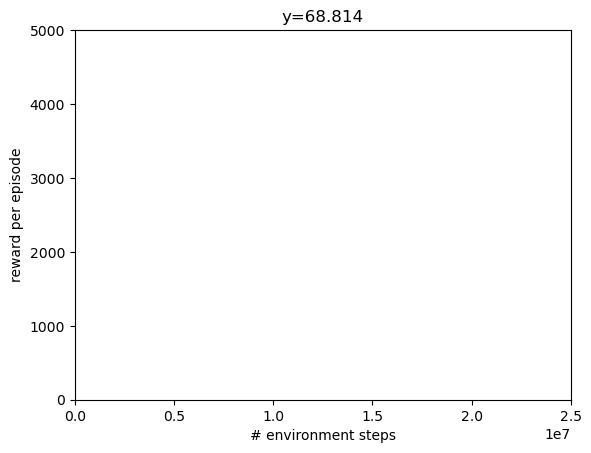

ctrl_cost: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/1)>
{'eval/walltime': 117.77570939064026, 'training/sps': 5968.816869163843, 'training/walltime': 384.2905638217926, 'training/entropy_loss': Array(nan, dtype=float32), 'training/policy_loss': Array(nan, dtype=float32), 'training/total_loss': Array(nan, dtype=float32), 'training/v_loss': Array(nan, dtype=float32), 'eval/episode_reward': Array(nan, dtype=float32), 'eval/episode_reward_quadctrl': Array(nan, dtype=float32), 'eval/episode_uph_cost': Array(nan, dtype=float32), 'eval/episode_reward_std': Array(nan, dtype=float32), 'eval/episode_reward_quadctrl_std': Array(nan, dtype=float32), 'eval/episode_uph_cost_std': Array(nan, dtype=float32), 'eval/avg_episode_length': Array(1000., dtype=float32), 'eval/epoch_eval_time': 29.08067488670349, 'eval/sps': 4401.54846813838}


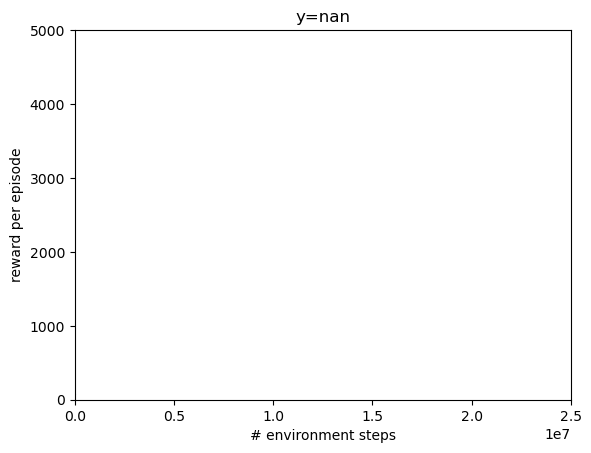

In [ ]:
make_inference_fn, params, _,ancestor_training_state = train_fn(environment=pt_env, progress_fn=progress)
print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')